<img src="yelp_logo.png" width="400">

# Analyzing Yelp Reviews

### Import libraries

In [53]:
from pyspark.sql import SparkSession
import pyspark
from pyspark import sql
import re
import pandas as pd
import numpy as np

### Create Spark session

In [54]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Load Data

In [55]:
path = 'yelp-dataset/yelp_academic_dataset_review.json'
reviews_df = spark.read.json(path)
reviews_df.count()

6685900

### Sample DF

In [56]:
reviews_df = reviews_df.sample(False, 0.0001)

### Check schema

In [57]:
# Check schema
reviews_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



### Check number of NULL values per column

In [58]:
for col in reviews_df.columns:
    print(col, ':', reviews_df.filter(reviews_df[col].isNull()).count())

business_id : 0
cool : 0
date : 0
funny : 0
review_id : 0
stars : 0
text : 0
useful : 0
user_id : 0


### View data

In [59]:
reviews_df.show(5)
reviews_df.count()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|aRNjAsmXv1pJTUWTt...|   0|2016-07-25 05:34:02|    0|4gsMjBlKGdWsdvytf...|  5.0|I don't usually r...|     1|H74Dv2uhRcfYurTwL...|
|r48H_sNUGmcRGX1Ls...|   0|2013-06-24 13:21:01|    0|NNHMeimS_JPdPFkG6...|  3.0|Food was dece. Se...|     0|QrIvOhNFzEBRUU2Rb...|
|cbdg2vJ6vM6Vq2EaJ...|   0|2016-10-01 17:19:34|    0|mVN3VPcaYJeGWN7sy...|  5.0|Boca Park Animal ...|     0|VlQMznj9u8TNqiyhN...|
|wNdTKpis6nxehbaZP...|   0|2017-12-17 19:32:32|    0|_yQSKU4yPFz2GxeUg...|  4.0|Really great menu...|     0|KVJEi32OjZUWWPjH1...|
|S5FTckOpSK0_Ma4c1...|   1|2013-12-10 05:07:26|    0|330C-YnKno6F57rp5...|  5.0|Found this

721

### Create dummy variable for high reviews (defined as a 4/5 or above)

In [60]:
from pyspark.sql import Row
from pyspark.sql.functions import col, when

In [61]:
review_docs_df = reviews_df.withColumn('d_stars',when(col('stars')>=4, 1).otherwise(0))
review_docs_df = review_docs_df.select('d_stars', 'text')
review_docs_df.show(5)

+-------+--------------------+
|d_stars|                text|
+-------+--------------------+
|      1|I don't usually r...|
|      0|Food was dece. Se...|
|      1|Boca Park Animal ...|
|      1|Really great menu...|
|      1|Found this place ...|
+-------+--------------------+
only showing top 5 rows



### Tokenize 'text' column

In [62]:
from pyspark.ml.feature import Tokenizer

In [63]:
# Create tokenizer object
tokenizer = Tokenizer().setInputCol('text').setOutputCol('tokens')

We can now transform the dataframe

In [64]:
tokenizer.transform(review_docs_df).show()

+-------+--------------------+--------------------+
|d_stars|                text|              tokens|
+-------+--------------------+--------------------+
|      1|I don't usually r...|[i, don't, usuall...|
|      0|Food was dece. Se...|[food, was, dece....|
|      1|Boca Park Animal ...|[boca, park, anim...|
|      1|Really great menu...|[really, great, m...|
|      1|Found this place ...|[found, this, pla...|
|      1|This place is oka...|[this, place, is,...|
|      0|I went to Juan's ...|[i, went, to, jua...|
|      0|I've eaten at Roc...|[i've, eaten, at,...|
|      1|Encore Beach Club...|[encore, beach, c...|
|      0|To me, this club ...|[to, me,, this, c...|
|      1|Know the owner Co...|[know, the, owner...|
|      1|Crazy beers on ta...|[crazy, beers, on...|
|      1|Best Hookah spot ...|[best, hookah, sp...|
|      0|Good place to sto...|[good, place, to,...|
|      0|I came in for din...|[i, came, in, for...|
|      1|I have returned t...|[i, have, returne...|
|      0|Abs

### Utilize CountVectorizer on new 'tokens' column

A `CountVectorizer` is different from a `Tokenizer` because it needs to learn how many different tokens there are in the input column. With that number, it will output vectors with consistent dimensions. Therefore, `CountVectorizer` is an `Estimator` that, when fitted, returns a `Transformer`.

In [65]:
from pyspark.ml.feature import CountVectorizer

In [66]:
count_vectorizer_estimator = CountVectorizer().setInputCol('tokens').setOutputCol('features')

Now we need to user the words column that was generated by the `tokenizer` transformer

In [67]:
count_vectorizer_transformer = count_vectorizer_estimator.fit(tokenizer.transform(review_docs_df))

which results in:

In [68]:
count_vectorizer_transformer.transform(tokenizer.transform(review_docs_df)).show(10)

+-------+--------------------+--------------------+--------------------+
|d_stars|                text|              tokens|            features|
+-------+--------------------+--------------------+--------------------+
|      1|I don't usually r...|[i, don't, usuall...|(11816,[0,1,2,3,4...|
|      0|Food was dece. Se...|[food, was, dece....|(11816,[6,25,38,4...|
|      1|Boca Park Animal ...|[boca, park, anim...|(11816,[0,1,2,4,5...|
|      1|Really great menu...|[really, great, m...|(11816,[0,1,4,5,9...|
|      1|Found this place ...|[found, this, pla...|(11816,[0,1,2,3,4...|
|      1|This place is oka...|[this, place, is,...|(11816,[0,1,2,3,4...|
|      0|I went to Juan's ...|[i, went, to, jua...|(11816,[0,1,2,3,4...|
|      0|I've eaten at Roc...|[i've, eaten, at,...|(11816,[0,1,2,3,4...|
|      1|Encore Beach Club...|[encore, beach, c...|(11816,[0,1,3,4,5...|
|      0|To me, this club ...|[to, me,, this, c...|(11816,[0,1,2,3,4...|
+-------+--------------------+--------------------+

### Create Machine Learning Pipeline

Sometimes, we have long preprocessing steps that take raw data and transform it through several stages. As explained before, these complex transformations can be captured by Pipelines.

Pipelines are always estimators, even when they contain several transformers. After a pipeline is `fit` to the data, the pipeline becomes an transformer.

We will now define a pipeline that takes the raw `text` column and produces the `features` column previously explained

In [69]:
from pyspark.ml import Pipeline

In [70]:
pipeline_cv_estimator = Pipeline(stages=[tokenizer, count_vectorizer_estimator])

In [71]:
pipeline_cv_transformer = pipeline_cv_estimator.fit(review_docs_df)

In more complex scenarios, you can even chain Pipeline transformers. We will see this case in the actual use case below.

For a more detail explanation of Pipelines, Estimators, and Transformers, [see here](http://spark.apache.org/docs/latest/ml-pipeline.html)

### Get stop words

In [72]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

### Remove stop words

In [73]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("tokens")\
  .setOutputCol("filtered_tokens")

### Create a counter vectorizer estimator

In [74]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered_tokens")\
  .setOutputCol("tf")

In [87]:
# we now create a pipelined transformer
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(review_docs_df)

In [90]:
cv_pipeline.transform(review_docs_df).show(5)

+-------+--------------------+--------------------+--------------------+--------------------+
|d_stars|                text|              tokens|     filtered_tokens|                  tf|
+-------+--------------------+--------------------+--------------------+--------------------+
|      1|I don't usually r...|[i, don't, usuall...|[don't, usually, ...|(1403,[0,6,11,15,...|
|      0|Food was dece. Se...|[food, was, dece....|[food, dece., ser...|(1403,[3,4,10,116...|
|      1|Boca Park Animal ...|[boca, park, anim...|[boca, park, anim...|(1403,[0,6,9,11,1...|
|      1|Really great menu...|[really, great, m...|[really, great, m...|(1403,[2,8,16,55,...|
|      1|Found this place ...|[found, this, pla...|[place, yelp., lo...|(1403,[0,1,3,4,5,...|
+-------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



The term frequency vector is represented with a sparse vector. We have 26,677 terms.

In [91]:
len(cv_pipeline.stages[-1].vocabulary)

1403

Finally, we build another pipeline that takes the output of the previous pipeline and _lowers_ the terms of documents that are very common.

In [79]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [93]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(review_docs_df)

In [95]:
idf_pipeline.transform(review_docs_df).show(5)

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|d_stars|                text|              tokens|     filtered_tokens|                  tf|               tfidf|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      1|I don't usually r...|[i, don't, usuall...|[don't, usually, ...|(1403,[0,6,11,15,...|(1403,[0,6,11,15,...|
|      0|Food was dece. Se...|[food, was, dece....|[food, dece., ser...|(1403,[3,4,10,116...|(1403,[3,4,10,116...|
|      1|Boca Park Animal ...|[boca, park, anim...|[boca, park, anim...|(1403,[0,6,9,11,1...|(1403,[0,6,9,11,1...|
|      1|Really great menu...|[really, great, m...|[really, great, m...|(1403,[2,8,16,55,...|(1403,[2,8,16,55,...|
|      1|Found this place ...|[found, this, pla...|[place, yelp., lo...|(1403,[0,1,3,4,5,...|(1403,[0,1,3,4,5,...|
+-------+--------------------+--------------------+--------------------+--------

Therefore, the `idf_pipeline` takes the raw text from the datafarme `imdb_reviews_df` and creates a feature vector called `tfidf`!

In [96]:
tfidf_df = idf_pipeline.transform(review_docs_df)
pd_tfidf_df = tfidf_df.toPandas()
print("pd_tfidf_df shape =", pd_tfidf_df.shape)

pd_tfidf_df shape = (721, 6)


In [97]:
lr_df = pd_tfidf_df[['d_stars', 'tfidf']]
lr_df.head()

,d_stars,tfidf
0,1,"(4.277223678772386, 0.0, 0.0, 0.0, 0.0, 0.0, 1..."
1,0,"(0.0, 0.0, 0.0, 1.3402781238331838, 1.30902558..."
2,1,"(4.811876638618934, 0.0, 0.0, 0.0, 0.0, 0.0, 1..."
3,1,"(0.0, 0.0, 2.422774221530327, 0.0, 0.0, 0.0, 0..."
4,1,"(0.5346529598465483, 2.331849473376812, 0.0, 1..."


The cell below prints out the 'tf' and 'tfidf' columns for the first 10 rows of the tfidf_df.  Note that the tfidf column is transformed to account for the frequency with which the word appears in the corpus.  Words that appear more often are penalized more than words that do not appear as frequently in the corpus.

# Data science pipeline for estimating sentiments

First, let's split the data into training, validation, and testing.

In [84]:
training_df, validation_df, testing_df = review_docs_df.randomSplit([0.6, 0.3, 0.1], seed = 151)

In [85]:
training_df.show(5)

+-------+--------------------+
|d_stars|                text|
+-------+--------------------+
|      0|Absolutely, total...|
|      0|Good place to sto...|
|      0|I came in for din...|
|      0|I went to Juan's ...|
|      0|To me, this club ...|
+-------+--------------------+
only showing top 5 rows



In [86]:
[training_df.count(), validation_df.count(), testing_df.count()]

[442, 218, 61]

One immediately apparent problem is that the number of features in the dataset is far larger than the number of training examples. This can lead to serious overfitting.

Let's look at this more closely. Let's apply a simple prediction model known as logistic regression.

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) will take the `tfidf` features and predict whether the review is positive (`score == 1`) or negative (`score == 0`).

In [178]:
from pyspark.ml.classification import LogisticRegression

In [179]:
lr = LogisticRegression().\
    setLabelCol('score').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

Lets create a pipeline transformation by chaining the `idf_pipeline` with the logistic regression step (`lr`)

In [180]:
lr_pipeline = Pipeline(stages=[idf_pipeline, lr]).fit(training_df)

Lets estimate the accuracy:

In [181]:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.8491076257436452|
+------------------+



The performance is much better than before.

The problem however is that we are overfitting because we have many features compared to the training examples:

For example, if we look at the weights of the features, there is a lot of noise:

In [182]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
print("num weights:", len(weights))

coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})
coeffs_df.head()

num weights: 26677


,word,weight
0,br,-0.159518
1,s,-0.011867
2,movie,0.107276
3,film,0.217781
4,t,-0.514780


The most negative words are:

In [183]:
coeffs_df.sort_values('weight').head(5)

,word,weight
19447,cleaver,-5.989684
19973,unbridled,-4.925661
24671,diligent,-4.616240
26094,disparaging,-4.426469
25566,bigot,-4.271894


And the most positive:

In [184]:
coeffs_df.sort_values('weight', ascending=False).head(5)

,word,weight
20678,praiseworthy,12.804713
25549,storywise,6.461079
24098,flocking,5.092318
25425,appreciable,4.824625
24865,ether,4.714711


But none of them make sense. What is happening? We are overfitting the data. Those words that don't make sense are capturing just noise in the reviews.

For example, the word `helming` appears in only three reviews:

In [185]:
helming_df = \
idf_pipeline.transform(training_df).\
    select('id', fn.explode('words').alias('word')).\
    where(fn.col('word') == 'helming').\
    join(training_df, 'id')

helming_pandas_df = helming_df.toPandas()

print("Num Rows in helming_pandas_df:", len(helming_pandas_df))
helming_pandas_df

Num Rows in helming_pandas_df: 3


,id,word,review,score
0,pos_2548,helming,Karloff and Lugosi - Together again! This is o...,1.0
1,pos_1550,helming,Fräulein Doktor is as good a demonstration as ...,1.0
2,neg_12396,helming,There aren't many good things to say at all ab...,0.0


# Regularization

One way to prevent overfitting during training is to modify the loss function and penalize weight values that are too large.

There are two major regularization techniques, one based on penalizing the squared value of the weight (called L2 or ridge regularization) and another based on penalizing the absolute value of the weight (called L1 or lasso regularization).

The unregularized logistic regression loss function is:

\begin{equation}
L_\theta(p(X),Y) = - \left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log (1-p_\theta(X_i)) \right)
\end{equation}

where $p_\theta(\cdot)$ is the sigmoid function:

\begin{equation}
p_\theta(X) = \frac{1}{1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))}
\end{equation}

If we modify the loss function $L_\theta$ slightly

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \theta_j^2
\end{equation}

we obtain what is known as L2 regularization.

Notice how we increase the loss function by $\lambda$ times the square of the weights. In practice, this means that __we will think twice about increasing the importance of a feature__. This loss function will prevent the algorithm for fitting certain data points, such as outliers or noise, unless the decrease in loss for the data grants it. Also, notice that the penalization doesn't apply to the bias parameter $\theta_0$.

You can see more clearly the effect of such cost function when $\lambda$ goes to infinity: the features will not be used for predicting and only the bias term will matter! This prevents the algorithm from learning altogether, forcing it to underfit!

One problem with L2 regularization is that all weights go to zero uniformly. In a sense, all features will matter but less than with the unregularized loss function. This is a really strange because we do not want all features to matter. In sentiment analysis, we want to select certain features because we want to understand that only some words have effects on the sentiment.

A different modification of the original loss function can achieve this. This regularization is known as L1 or lasso reguarlization and penalizes the _absolute_ value of the weight

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \left| \theta_j \right|
\end{equation}

The practical effect of L1 regularization is that the difference between a feature having no importance vs some small importance is massively bigger than with L2 regularization. __Therefore, optimizing the L1 loss function usually brings some features to have exactly zero weight.__

One problem with L1 regularization is that it will never select more features than the number of examples. This is because it can always fit the training data perfectly when the number of features equals the number of examples. In our sentimental analysis, this is the case (there are more words than examples).

One way of remedying this is to have a combination of both L1 and L2. This is known as __elastic net regularization__. For this type of regularization, we have to pick a parameter ($\alpha$) deciding to consider L1 vs L2 regularization. If $\alpha=0$, then we choose L2, and if $\alpha=1$ we choose L1. For example, $\alpha=0.5$ means half L1 and half L2.

\begin{equation}
L_\theta^{\lambda,\alpha}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log (1-p_\theta(X_i)) \right) + \lambda \left[(1-\alpha) \sum_{j>0} \theta_j^2 + \alpha \sum_{j>0} \left| \theta_j \right| \right]
\end{equation}

Unfortunately, elastic net regularization comes with two additional parameters, $\lambda$ and $\alpha$, and we must either select them a priori or use the validation set to choose the best one.

## Spark allows us to fit elastic net regularization easily

In [186]:
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

And we define a new Pipeline with all steps combined

In [187]:
en_lr_estimator = Pipeline(
    stages=[tokenizer, sw_filter, cv, idf, en_lr])

In [188]:
en_lr_pipeline = en_lr_estimator.fit(training_df)

Let's look at the performance

In [189]:
en_lr_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = score)'))).show()

+--------------------------------+
|avg(float((prediction = score)))|
+--------------------------------+
|               0.866955110870741|
+--------------------------------+



We improve performance slightly, but whats more important is that we improve the understanding of the word sentiments. Lets look at the weights:

In [190]:
en_weights = en_lr_pipeline.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': en_lr_pipeline.stages[2].vocabulary, 'weight': en_weights})

The most negative words all make sense ("worst" is _actually_ more negative than than "worse")!

In [191]:
en_coeffs_df.sort_values('weight').head(15)

,word,weight
104,worst,-0.359844
253,waste,-0.352669
204,awful,-0.268944
11,bad,-0.252437
1140,disappointment,-0.222550
625,poorly,-0.199626
198,boring,-0.193945
249,worse,-0.192057
547,avoid,-0.181627
329,horrible,-0.180874


Same thing with positive words

In [192]:
en_coeffs_df.sort_values('weight', ascending=False).head(15)

,word,weight
12,great,0.292210
158,excellent,0.251008
19199,tagged,0.202634
218,wonderful,0.200991
2205,refreshing,0.180733
223,perfect,0.180121
26,best,0.178514
319,amazing,0.166876
680,superb,0.145299
12681,teaming,0.133247


Are there words with _literarily_ zero importance for predicting sentiment? Yes, and most of them!

In [193]:
en_coeffs_df.query('weight == 0.0').shape

(19561, 2)

In fact, approximately 95% of features are not needed to achieve a __better__ performance than all previous models!

In [194]:
en_coeffs_df.query('weight == 0.0').shape[0]/en_coeffs_df.shape[0]

0.9479525078749698

Let's look at these _neutral_ words

In [195]:
en_coeffs_df.query('weight == 0.0').head(15)

,word,weight
0,br,0.0
1,s,0.0
2,movie,0.0
3,film,0.0
5,like,0.0
10,really,0.0
13,people,0.0
14,don,0.0
15,way,0.0
17,movies,0.0


But, did we choose the right $\lambda$ and $\alpha$ parameters? We should run an experiment where we try different combinations of them. Fortunately, Spark let us do this by using a grid - a method that generates combination of parameters.

In [196]:
from pyspark.ml.tuning import ParamGridBuilder

We need to build a new estimator pipeline

In [197]:
en_lr_estimator.getStages()

[RegexTokenizer_544481ac1529,
 StopWordsRemover_26badab38b1a,
 CountVectorizer_b034ec4fc20d,
 IDF_484abffecc80,
 LogisticRegression_c46d76150c3c]

In [198]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

This is the list of parameters that we will try:

In [199]:
grid

[{Param(parent='LogisticRegression_c46d76150c3c', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_c46d76150c3c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_c46d76150c3c', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_c46d76150c3c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LogisticRegression_c46d76150c3c', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_c46d76150c3c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4},
 {Pa

In [200]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [201]:
# estimate the accuracy of each of them:
accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

In [202]:
accuracies

[0.8497836668469443,
 0.8497836668469443,
 0.8497836668469443,
 0.8688480259599783,
 0.872093023255814,
 0.8724986479177934,
 0.8726338561384532,
 0.8747971876690103,
 0.8569497025419145]

In [203]:
import numpy as np

In [204]:
best_model_idx = np.argmax(accuracies)
print("best model index =", best_model_idx)

best model index = 7


So the best model we found has the following parameters

In [205]:
grid[best_model_idx]

{Param(parent='LogisticRegression_c46d76150c3c', name='regParam', doc='regularization parameter (>= 0).'): 0.02,
 Param(parent='LogisticRegression_c46d76150c3c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}

In [206]:
best_model = all_models[best_model_idx]

In [207]:
accuracies[best_model_idx]

0.8747971876690103

In [208]:
# estimate generalization performance
best_model.\
    transform(testing_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    show()

+------------------+
|          accuracy|
+------------------+
|0.8852459016393442|
+------------------+



## Finally, predicting tweet sentiments

Now we can use this model to predict sentiments on Twitter

In [209]:
tweets_df = spark.read.parquet('tweets.parquet')
#tweets_df.show(5, truncate=False)
tweets_df.show(5)

+--------------------+---------------+
|                text|         handle|
+--------------------+---------------+
|RT @ZekeJMiller: ...|@HillaryClinton|
|“She’s just out t...|@HillaryClinton|
|We're going to ma...|@HillaryClinton|
|Don't boo. Vote! ...|@HillaryClinton|
|This Republican d...|@HillaryClinton|
+--------------------+---------------+
only showing top 5 rows



We have 1K tweets from each candidate

In [210]:
tweets_df.groupby('handle').agg(fn.count('*')).show()

+----------------+--------+
|          handle|count(1)|
+----------------+--------+
| @HillaryClinton|    1000|
|@realDonaldTrump|    1000|
+----------------+--------+



We can now predict the sentiment of the Tweet using our best model, we need to rename the column so that it matches our previous pipeline (`review` => ...)

In [211]:
best_model.transform(tweets_df.withColumnRenamed('text', 'review')).select('handle', 'review', 'prediction').show()

+---------------+--------------------+----------+
|         handle|              review|prediction|
+---------------+--------------------+----------+
|@HillaryClinton|RT @ZekeJMiller: ...|       1.0|
|@HillaryClinton|“She’s just out t...|       0.0|
|@HillaryClinton|We're going to ma...|       0.0|
|@HillaryClinton|Don't boo. Vote! ...|       0.0|
|@HillaryClinton|This Republican d...|       0.0|
|@HillaryClinton|Hillary teamed up...|       0.0|
|@HillaryClinton|RT @mayaharris_: ...|       1.0|
|@HillaryClinton|"It was overwhelm...|       0.0|
|@HillaryClinton|Great step forwar...|       1.0|
|@HillaryClinton|"I feel like I'm ...|       0.0|
|@HillaryClinton|Nobody here was “...|       1.0|
|@HillaryClinton|For those few peo...|       1.0|
|@HillaryClinton|Remember, don't b...|       1.0|
|@HillaryClinton|Too many talented...|       1.0|
|@HillaryClinton|There are hundred...|       0.0|
|@HillaryClinton|It's 3:20am. As g...|       1.0|
|@HillaryClinton|Trump stood on a ...|       1.0|


Now, lets summarize our results in a graph!

In [212]:
%matplotlib inline

In [213]:
import seaborn

In [214]:
sentiment_pd = best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    groupby('handle').\
    agg(fn.avg('prediction').alias('prediction'), (2*fn.stddev('prediction')/fn.sqrt(fn.count('*'))).alias('err')).\
    toPandas()

In [215]:
sentiment_pd.head()

,handle,prediction,err
0,@HillaryClinton,0.741,0.027721
1,@realDonaldTrump,0.816,0.024519


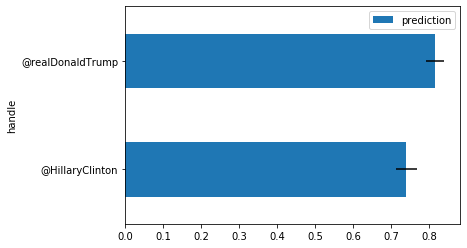

In [222]:
sentiment_pd.plot(x='handle', y='prediction', xerr='err', kind='barh');

But let's examine some "negative" tweets by Trump

In [217]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@realDonaldTrump').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='Moderator: Hillary paid $225,000 by a Brazilian bank for a speech that called for “open borders.” That’s a quote! #Debate #BigLeagueTruth'),
 Row(review='Hillary is too weak to lead on border security-no solutions, no ideas, no credibility.She supported NAFTA, worst deal in US history. #Debate'),
 Row(review='UNBELIEVABLE!\nClinton campaign contractor caught in voter-fraud video is a felon who visited White House 342 times: https://t.co/qQdsMHAtkT'),
 Row(review='More Anti-Catholic Emails From Team Clinton: https://t.co/KYirBbYjp2 https://t.co/f8Z7olUvlM'),
 Row(review='‘Food Groups’ – Emails Show Clinton Campaign Organized Potential VPs By Race And Gender: https://t.co/Qk1fOm1t8L')]

And Clinton

In [218]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@HillaryClinton').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='“She’s just out there every day doing God’s work in her own way. You know? Making her parents proud.” —Betsy, Hilla… https://t.co/ZB3Vxskqoh'),
 Row(review="We're going to make college debt-free for everyone in America. See how much you could save with Hillary's plan at… https://t.co/Fhzkubhpj7"),
 Row(review="Don't boo. Vote! https://t.co/tTgeqy51PU https://t.co/9un3FUVxoG"),
 Row(review='This Republican dad is struggling with the idea of his daughter growing up in a country led by Donald Trump. https://t.co/Tn3rQqJJKp'),
 Row(review='Hillary teamed up with @BernieSanders on a plan to make college debt-free for all Americans. https://t.co/sdWVzdxIrG')]

As you can see, there are lots of room for improvement.